In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from datetime import datetime
from types import SimpleNamespace
import os
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchmetrics import MeanAbsoluteError, MeanSquaredError
import xarray
import pandas as pd
from dataset.dataset import ImageDataset, SingleImageDataset, pickle_write
from dataset.normalization import MinMax, ZeroMinMax
from dataset.station_dataset import GroundstationDataset, GroundstationDataset2
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from models.ConvResNet_Jiang import ConvResNet, ConvResNet_dropout, ConvResNet_batchnormMLP
from models.LightningModule import LitEstimator, LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils.plotting import prediction_error_plot, plot_station_scatter
from captum.attr import FeaturePermutation, ShapleyValueSampling, IntegratedGradients, FeatureAblation
from cartopy.mpl.gridliner import (
    LongitudeFormatter,
    LatitudeFormatter,
    LongitudeLocator,
    LatitudeLocator,
)
plt.rcParams['text.usetex'] = False

In [ ]:
config = {
    "batch_size": 2048,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS"],
    "x_features": ["dayofyear", "lat", "lon", "SZA", "AZI"],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
}
config = SimpleNamespace(**config)

trans = {
            "VIS006": "channel_1",
            "VIS008": "channel_2",
            "IR_016": "channel_3",
            "IR_039": "channel_4",
            "WV_062": "channel_5",
            "WV_073": "channel_6",
            "IR_087": "channel_7",
            "IR_097": "channel_8",
            "IR_108": "channel_9",
            "IR_120": "channel_10",
            "IR_134": "channel_11",
            "DEM":"DEM",
}

inv_trans = {v: k for k, v in trans.items()}
x_vars_trans = [inv_trans[nm] for nm in config.x_vars]

In [159]:


# chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/4nbyae30/checkpoints/epoch=5-val_loss=0.01038.ckpt'# SARAH3 emulator
# chkpt_fn = '../train/SIS_point_estimation_groundstation/pl86of1b/checkpoints/epoch=4-val_loss=0.01630.ckpt' # finetuned on 80 DWD groundstations
chkpt_fn = '../train/SIS_point_estimation_groundstation/groundstations_only/checkpoints/epoch=10-val_loss=0.01703.ckpt' # trained only on 80 DWD groundstations

inference_fn = chkpt_fn.split('checkpoints')[0] + 'inference/'
run_id = chkpt_fn.split('/checkpoints')[0].split('/')[-1]
if not os.path.exists(inference_fn):
    os.mkdir(inference_fn)

model = ConvResNet_batchnormMLP(
    num_attr=len(config.x_features),
    input_channels=len(config.x_vars),
    output_channels=len(config.y_vars),
)

estimator = LitEstimatorPoint.load_from_checkpoint(
    chkpt_fn,
    learning_rate=0.001,
    model=model,
    config=config,
)
estimator.eval()
print(run_id)
save_path = f'feature_importance/{run_id}/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

groundstations_only


In [160]:
def get_gsdataset(fn):
    return GroundstationDataset2(fn, config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                   config.transform, config.target_transform, sarah_idx_only=True)


# TAT_fn = '../../ZARR/IEA_PVPS/IEA_PVPS-TAT.zarr'
# CAB_fn = '../../ZARR/IEA_PVPS/IEA_PVPS-CAB.zarr'
# TAT = get_gsdataset(TAT_fn)
# CAB = get_gsdataset(CAB_fn)

bsrn_fns = glob('../../ZARR/IEA_PVPS/IEA_PVPS-*.zarr')
bsrn_datasets = {fn.split('PVPS-')[-1].replace('.zarr', ''):get_gsdataset(fn) for fn in tqdm(bsrn_fns)}
bsrn_dataset_all = ConcatDataset(bsrn_datasets.values())


100%|██████████| 14/14 [02:25<00:00, 10.37s/it]


In [161]:
dl_all = DataLoader(bsrn_dataset_all, shuffle=True, batch_size=20000)


In [162]:

patch = torch.ones((15,15))
X_feature_mask = torch.stack([patch *i for i in range(len(config.x_vars))]).unsqueeze(0).to(torch.int) # 1 x 12 x 15 x 15
x_feature_mask = torch.tensor(range(len(config.x_features))).unsqueeze(0).to(torch.int) # 1 x 5
feature_mask = (X_feature_mask, x_feature_mask) 

In [163]:

metric = MeanSquaredError().cuda()

@torch.no_grad()
def forward_func(X, x, y):
    y_hat = estimator(X.cuda(),x.cuda())
    y = y.cuda()
    loss = metric(y,y_hat)
    # prediction_error_plot(config.transform.inverse(y, ['SIS']),config.transform.inverse(y_hat, ['SIS']))
    # print(loss)
    return loss

feature_perm = FeaturePermutation(forward_func)

# for X,x,y in dl:
#     forward_func(X,x,y)

In [164]:
def feature_importance_dl(dl):
    x_attrs = []
    X_attrs = []

    for X, x, y in tqdm(dl):

        X_attr, x_attr = feature_perm.attribute((X,x), feature_mask=feature_mask, additional_forward_args=y)
        X_attr_channel = -1*X_attr.mean(dim=(2,3)).squeeze()
        x_attr = -1*x_attr.squeeze()
        x_attrs.append(x_attr)
        X_attrs.append(X_attr_channel)
    
    return X_attrs, x_attrs

X_attrs, x_attrs = feature_importance_dl(dl_all)


100%|██████████| 12/12 [05:38<00:00, 28.20s/it]


In [165]:
X_attrs_all = torch.stack(X_attrs)
x_attrs_all = torch.stack(x_attrs)

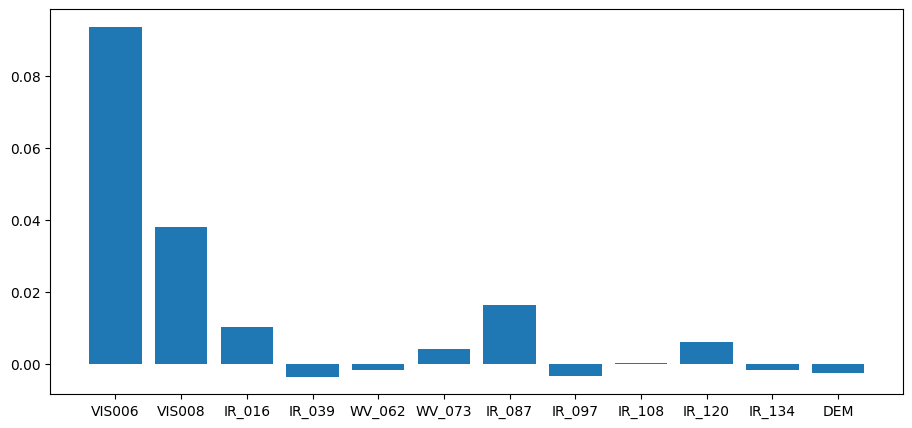

In [166]:
X_attrs_max = X_attrs_all.max(axis=0).values
X_attrs_min = X_attrs_all.min(axis=0).values

x_attrs_max = x_attrs_all.max(axis=0).values
x_attrs_min = x_attrs_all.min(axis=0).values

plt.figure(figsize=(11,5))
plt.bar(x_vars_trans, X_attrs_all.mean(0),)
# plt.errorbar(x_vars_trans, X_attrs_all.mean(0), yerr=torch.stack((X_attrs_max, X_attrs_min)),  fmt='.', color='Black', elinewidth=2,capthick=2,errorevery=1, alpha=0.5, ms=4, capsize = 2)
# plt.scatter(x_vars_trans, X_attrs_max, c='k', marker='_')
# plt.scatter(x_vars_trans, X_attrs_min, c='k', marker='_')
# plt.vlines(x_vars_trans, ymin = X_attrs_min, ymax = X_attrs_max, color='k')

plt.savefig( save_path + 'X_attrs.png')

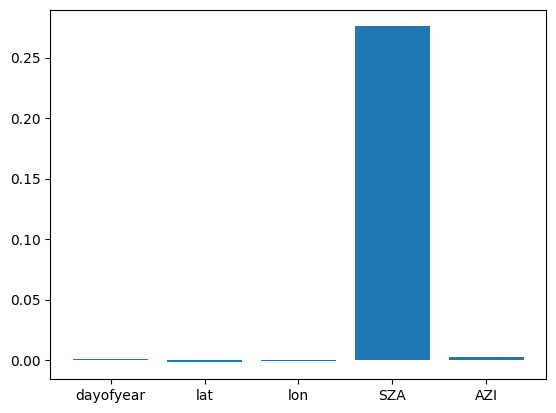

In [167]:
plt.bar(config.x_features, x_attrs_all.mean(0))
# plt.scatter(config.x_features, x_attrs_max, c='k', marker='_')
# plt.scatter(config.x_features, x_attrs_min, c='k', marker='_')
# plt.vlines(config.x_features, ymin = x_attrs_min, ymax = x_attrs_max, color='k')
# # plt.ylim([0,0.01])
plt.savefig(save_path + 'x_attrs.png')

In [ ]:
for nm, ds in bsrn_datasets.items():
    
    dl = DataLoader(ds, shuffle=False, batch_size=10000)
    X_attrs, x_attrs = feature_importance_dl(dl)
    
    X_attrs_all = torch.stack(X_attrs)
    x_attrs_all = torch.stack(x_attrs)
    
    X_attrs_max = X_attrs_all.max(axis=0).values
    X_attrs_min = X_attrs_all.min(axis=0).values

    x_attrs_max = x_attrs_all.max(axis=0).values
    x_attrs_min = x_attrs_all.min(axis=0).values

    plt.figure(figsize=(11,5))
    plt.bar(x_vars_trans, X_attrs_all.mean(0),)
    # plt.scatter(x_vars_trans, X_attrs_max, c='k', marker='_')
    # plt.scatter(x_vars_trans, X_attrs_min, c='k', marker='_')
    # plt.vlines(x_vars_trans, ymin = X_attrs_min, ymax = X_attrs_max, color='k')
    plt.savefig( save_path + f'{nm}_X_attrs.png')
    
    plt.figure()
    plt.bar(config.x_features, x_attrs_all.mean(0))
    # plt.scatter(config.x_features, x_attrs_max, c='k', marker='_')
    # plt.scatter(config.x_features, x_attrs_min, c='k', marker='_')
    # plt.vlines(config.x_features, ymin = x_attrs_min, ymax = x_attrs_max, color='k')
    plt.savefig(save_path + f'{nm}_x_attrs.png')

In [ ]:


featureab = FeatureAblation(forward_func)
                                
X_attr, x_attr = featureab.attribute((X,x), feature_mask=feature_mask, additional_forward_args=y)
X_attr_channel = X_attr.mean(dim=(2,3)).squeeze()


In [ ]:
plt.figure(figsize=(11,5))
plt.bar(x_vars_trans, X_attr_channel)

In [ ]:
plt.bar(config.x_features, x_attr.squeeze())

In [ ]:
def forward_func_grad(X, x, y):
    y_hat = estimator(X.cuda(),x.cuda())
    y = y.cuda()
    loss = metric(y,y_hat)
    return loss


intgrad = IntegratedGradients(forward_func_grad)

In [ ]:
dl = DataLoader(TAT, shuffle=False, batch_size=100)
for X,x,y in dl:
    break

intgrad.attribute((X,x),  additional_forward_args=y)